# Cropping landsat scenes out of their bouding box 

# Loading image and stac data

In [5]:
import tifffile as tiff
import numpy as np
data_file = "./data_sa/"

def get_rgb(ID):
    
    # Load Blue (B2), Green (B3) and Red (B4) bands
    R = tiff.imread(data_file +'{}/{}_SR_B4.TIF'.format(ID, ID))
    G = tiff.imread(data_file +'{}/{}_SR_B3.TIF'.format(ID, ID))
    B = tiff.imread(data_file +'{}/{}_SR_B2.TIF'.format(ID, ID))

    # Stack and scale bands
    RGB = np.dstack((R, G, B))
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.2)/0.2
    
    return RGB

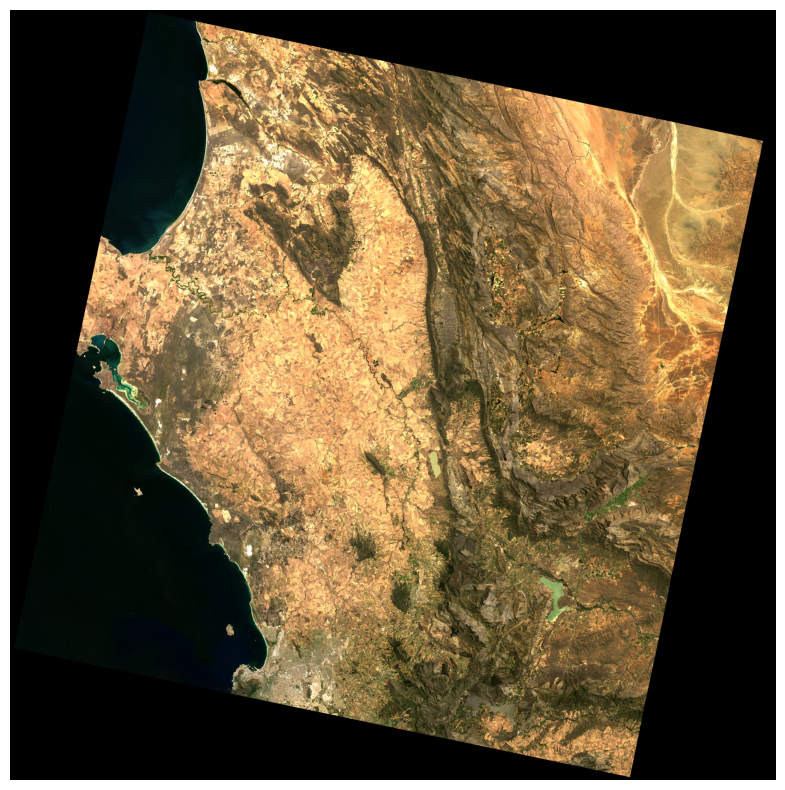

In [6]:
import matplotlib.pyplot as plt

# Get RGB image
ID = "LC08_L2SP_175083_20131218_20200912_02_T1"
RGB= get_rgb(ID)

# Display band
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(RGB)

ax.set_axis_off()

In [10]:
import json 

STAC = json.load(open(data_file + '{}/{}_SR_stac.json'.format(ID, ID)))
geometry = STAC['geometry']
geometry

{'type': 'Polygon',
 'coordinates': [[[18.159550315898603, -32.12468245140247],
   [17.668909952048097, -33.837483307834724],
   [19.65885130745987, -34.22421338418657],
   [20.11035058746359, -32.5047109940128],
   [18.159550315898603, -32.12468245140247]]]}

# Get pixel coordinates of bounding box 

In [25]:
import rasterio as rio

B4 = rio.open(data_file + '{}/{}_SR_B4.TIF'.format(ID, ID))
print(B4.crs) # UTM zone 34N

EPSG:32634


In [23]:
import utm 

pixel_coords = []
utm_coords = []

for coord in geometry['coordinates'][0]:

    # Get latitude and longitude
    lon = coord[0]
    lat = coord[1]

    # Convert to UTM
    utmx, utmy, _, _ = utm.from_latlon(lat, lon, force_zone_number=34) 
    utm_coords.append([utmx, utmy])

    # Remove false northing
    if lat< 0:
        utmy = utmy - 10000000

    # Get pixel coordinates
    y,x = B4.index(utmx, utmy)
    pixel_coords.append([x,y])
    

print(B4.bounds)
print(pixel_coords)

BoundingBox(left=190485.0, bottom=-3788715.0, right=420315.0, top=-3557385.0)
[[1384, 13], [41, 6391], [6199, 7681], [7531, 1311], [1384, 13]]


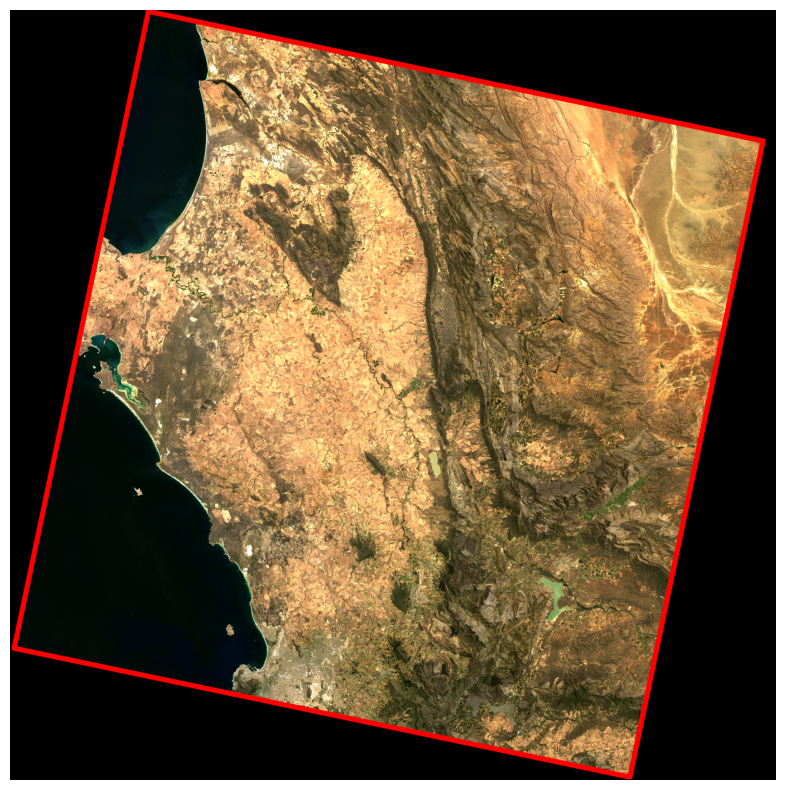

In [13]:
import cv2

RGB_ = RGB.copy()

# draw box around scene
for i in range(len(pixel_coords)-1):
    x1,y1 = pixel_coords[i]
    x2,y2 = pixel_coords[i+1]

    RGB_ = cv2.line(RGB_, (x1,y1), (x2, y2), [1,0,0],50)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(RGB_)
ax.set_axis_off()

# Calculate angel of rotation

In [14]:
import math

def angle_between(p1, p2):
    """Calculate the degree between two points"""
    x1, y1 = p1
    x2, y2 = p2

    degree = math.atan2(y2-y1, x2-x1) * 180 / math.pi

    return degree

/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11.923415486558927


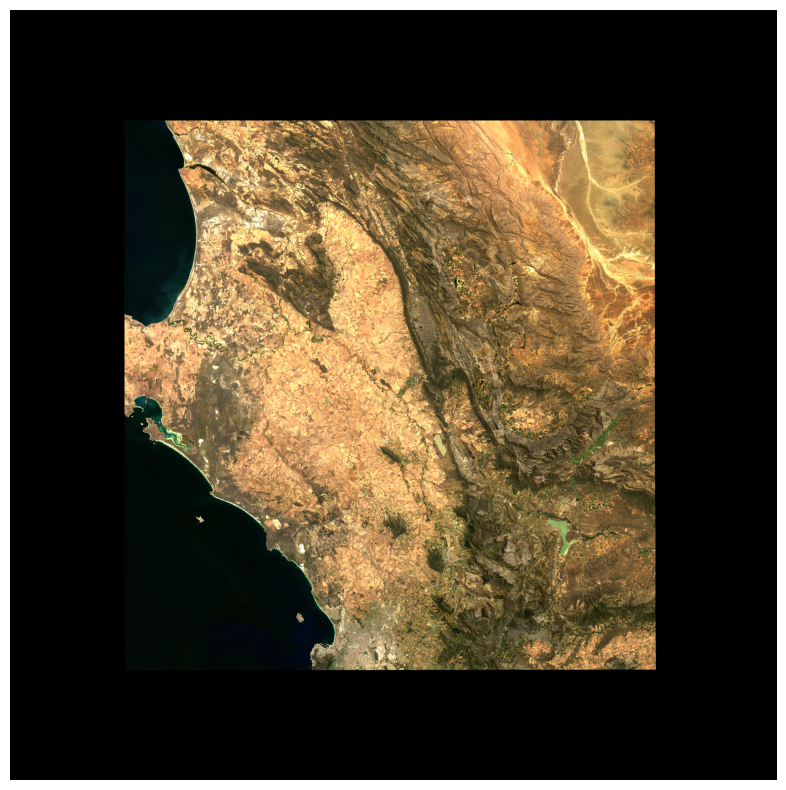

In [16]:
from scipy.ndimage import rotate

rot_RGB = RGB.copy()

# Get angle between points
angle = angle_between(pixel_coords[0], pixel_coords[3])

# Rotate image
rot_RGB = rotate(RGB, angle, reshape=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(rot_RGB)
ax.set_axis_off()

print(angle)


# Get rotated pixel coordinates

In [17]:
def get_rotated_coords(xy, angle, org_center, rot_center):
    
    """Find the new coordinates after rotation"""
    
    # Translate to center
    xy_orgin = xy-org_center

    # Get angle in radians
    a = np.deg2rad(angle)

    # Rotate around origin
    rot_x = np.round(xy_orgin[0]*np.cos(a) + xy_orgin[1]*np.sin(a))
    rot_y = np.round(-xy_orgin[0]*np.sin(a) + xy_orgin[1]*np.cos(a))
    rot_xy_orgin  = np.array([rot_x, rot_y])
    
    # Translate back to rot_center
    xy_rotated = rot_xy_orgin + rot_center
    xy_rotated = xy_rotated.astype(int)

    return xy_rotated

In [18]:
# Get center coordinates
org_center = (np.array(RGB.shape[:2][::-1])-1)/2.
rot_center = (np.array(rot_RGB.shape[:2][::-1])-1)/2.

rot_pixel_coords = []

for coord in pixel_coords:
    # Rotate each pixel of scene box
    rot_coords = get_rotated_coords(coord, angle, org_center, rot_center)
    rot_pixel_coords.append(rot_coords)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


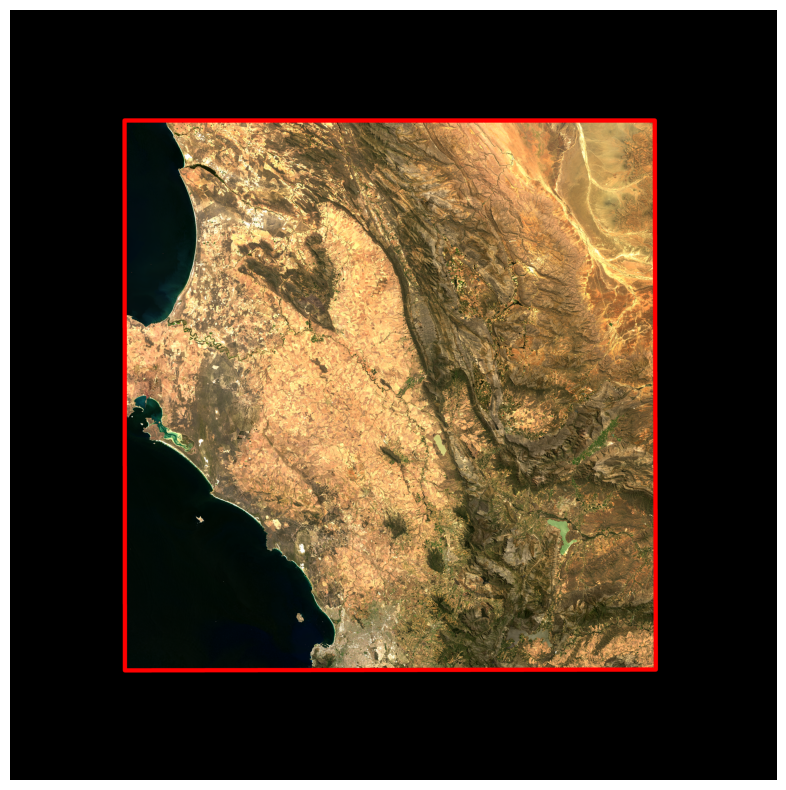

In [19]:
import cv2

RGB__ = rot_RGB.copy()

# draw box around scene
for i in range(len(rot_pixel_coords)-1):
    x1,y1 = rot_pixel_coords[i]
    x2,y2 = rot_pixel_coords[i+1]

    RGB__ = cv2.line(RGB__, (x1,y1), (x2, y2), [1,0,0],50)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(RGB__)
ax.set_axis_off()

# Crop image

In [21]:
# find min and max coordinates of rotated box
xmax = max([x for x,y in rot_pixel_coords])
xmin = min([x for x,y in rot_pixel_coords])

ymax = max([y for x,y in rot_pixel_coords])
ymin = min([y for x,y in rot_pixel_coords])

print(xmin, xmax, ymin, ymax)

1357 7652 1309 7827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


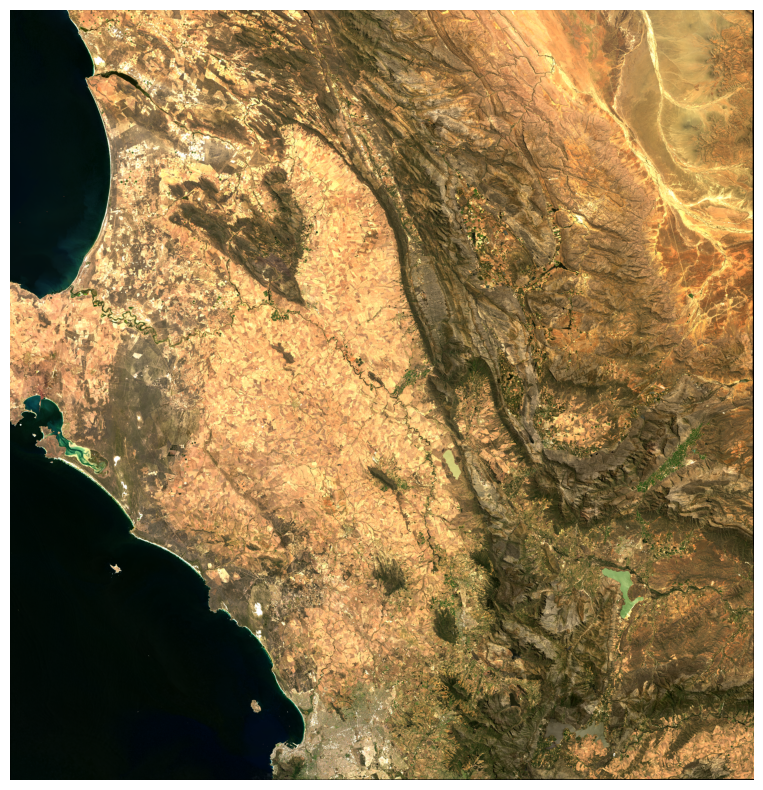

In [22]:
crop_RGB = rot_RGB.copy()

# Crop image
crop_RGB = crop_RGB[ymin:ymax, xmin:xmax, :]

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(crop_RGB)
ax.set_axis_off()

In [26]:

from rasterio import mask

# Create a polygon geometry from utm coordinates
geometry = {'type': 'Polygon', 'coordinates': [utm_coords]}

# Clip the raster with polygon
out_image, out_transform = mask.mask(B4, [geometry], crop=True)

ValueError: Input shapes do not overlap raster.